In [1]:
# Important libraries
import os
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

# NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Keras library
import tensorflow
from tensorflow import keras, random
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Set random seed
random.set_seed(123)

Using TensorFlow backend.


In [2]:
# Load in datasets
train = pd.read_csv("./data/train.tsv.zip", sep="\t")
test = pd.read_csv("./data/test.tsv.zip", sep="\t")
print('Train shape:', train.shape)
train.head()

Train shape: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
# Inspect test dataset
print('Test shape:', test.shape)
test.head()

Test shape: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


# Preprocessing

Let's define a function that will remove --
* remove html content
* remove non-alphabetic characters
* tokenize the sentences
* lemmatize each word to its lemma

In [3]:
def clean_text(df):
    '''
    A function for cleaning the reviews, tokenize and lemmatize them
    '''
    # instantiate an empty list
    reviews = []
    
    # loop over the entire text
    for sent in tqdm(df['Phrase']):
    
        # remove html content
        review_text = BeautifulSoup(sent, "html.parser").get_text()

        # remove non-alphabetic characters
        review_text = re.sub('[^a-zA-Z]', ' ', review_text)

        # tokenize the sentences
        words = word_tokenize(review_text.lower())

        # lemmatize the words
        lemma_words = [lemmatizer.lemmatize(w) for w in words]

        # append to the list
        reviews.append(lemma_words)
    
    return reviews

In [4]:
# Get cleaned text
train_sent = clean_text(train)
test_sent = clean_text(test)

  0%|          | 1/156060 [00:01<64:09:37,  1.48s/it]C:\Users\heydi\anaconda3\lib\site-packages\bs4\__init__.py:312: UserWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)
  0%|          | 467/156060 [00:01<44:46:51,  1.04s/it]C:\Users\heydi\anaconda3\lib\site-packages\bs4\__init__.py:312: UserWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)
100%|██████████| 66292/66292 [00:14<00:00, 4620.24it/s]


In [6]:
print(len(train_sent))
print(len(test_sent))

156060
66292


In [7]:
# Set the features values
target = train['Sentiment'].to_numpy()
y_target = to_categorical(target)
print('No of classes:', y_target.shape[1])

No of classes: 5


In [8]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_sent, y_target, 
                                                  stratify=y_target,
                                                  test_size=0.20)

In [9]:
# Derive unique words and maximum length of a review
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    unique_words.update(sent)
    
    if len_max<len(sent):
        len_max = len(sent)
        
num_words = len(list(unique_words))
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 715322.58it/s]

13739
48


In [10]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [11]:
# Text to sequence
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sent)

In [12]:
# Padding
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

In [13]:
print('X_train:', X_train.shape)
print('X_val:', X_val.shape)
print('X_test:', X_test.shape)

X_train: (124848, 48)
X_val: (31212, 48)
X_test: (66292, 48)


In [14]:
# Set early stopping
early_stopping = EarlyStopping(min_delta=0.001, mode='max', monitor='val_acc', patience=2)
callback = [early_stopping]

# LSTM Model

In [15]:
num_classes = y_target.shape[1]

model = Sequential()
model.add(Embedding(num_words, 300, input_length=len_max))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 300)           4121700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 4,397,761
Trainable params: 4,397,761
Non-trainable params: 0
____________________________________________

In [16]:
# Fit the model
history=model.fit(X_train, y_train, validation_data=[X_val, y_val],
                 epochs=10, batch_size=20, verbose=1, callbacks=callback)

C:\Users\heydi\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 697s 6ms/step - loss: 1.0101 - accuracy: 0.5947 - val_loss: 0.8687 - val_accuracy: 0.6448
Epoch 2/10
    20/124848 [..............................] - ETA: 11:30 - loss: 0.7317 - accuracy: 0.8000

C:\Users\heydi\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


124848/124848 [==============================] - 668s 5ms/step - loss: 0.8234 - accuracy: 0.6637 - val_loss: 0.8235 - val_accuracy: 0.6641
Epoch 3/10
124848/124848 [==============================] - 673s 5ms/step - loss: 0.7651 - accuracy: 0.6893 - val_loss: 0.8107 - val_accuracy: 0.6678
Epoch 4/10
124848/124848 [==============================] - 662s 5ms/step - loss: 0.7296 - accuracy: 0.7029 - val_loss: 0.8124 - val_accuracy: 0.6744
Epoch 5/10
124848/124848 [==============================] - 686s 5ms/step - loss: 0.7021 - accuracy: 0.7147 - val_loss: 0.8208 - val_accuracy: 0.6726
Epoch 6/10
124848/124848 [==============================] - 697s 6ms/step - loss: 0.6841 - accuracy: 0.7242 - val_loss: 0.8132 - val_accuracy: 0.6723
Epoch 7/10
124848/124848 [==============================] - 691s 6ms/step - loss: 0.6684 - accuracy: 0.7296 - val_loss: 0.8221 - val_accuracy: 0.6753
Epoch 8/10
124848/124848 [==============================] - 717s 6ms/step - loss: 0.6540 - accuracy: 0.7364 - v

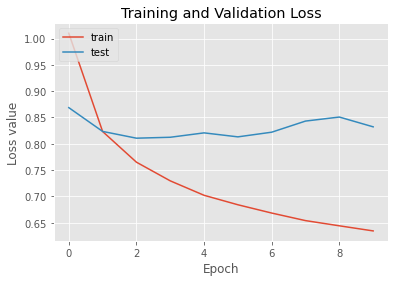

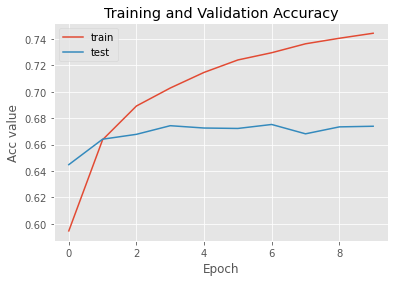

In [17]:
#  Model Evaluation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()